# Problem Statement

A bike-sharing system is a service in which bikes are made available for shared use to individuals on a short term basis for a price or free. Many bike share systems allow people to borrow a bike from a "dock" which is usually computer-controlled wherein the user enters the payment information, and the system unlocks it. This bike can then be returned to another dock belonging to the same system.

A bike sharing company BikesForUs aspires to understand the demand for shared bikes among the people after this ongoing quarantine situation ends across the nation due to Covid-19. They have planned this to prepare themselves to cater to the people's needs once the situation gets better all around and stand out from other service providers and make huge profits.

# Business Goal
To model the demand for shared bikes with the available independent variables. The model will be a good way for the company's management to understand the demand dynamics of a new market.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

In [96]:
df=pd.read_csv(r'F:\projects/day.csv')

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


# 2 Preprocessing the data

In [98]:
df = df.drop('dteday', axis=1)

Consider 'registered' & 'casual' columns, we know that registered + casual = cnt. So a very straight forward linear relationship exists.
Hence, we cannot keep these raw variables as such or they will skew our model. Let us introduce a new variable casualvsregistered

In [99]:
df['casualvsregistered'] = df['casual']/df['registered']
df = df.drop('casual', axis=1)
df = df.drop('registered', axis=1)
df.head()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,casualvsregistered
0,1,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,985,0.506116
1,2,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,801,0.195522
2,3,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,1349,0.097640
3,4,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,1562,0.074278
4,5,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,1600,0.054018


C:\Users\ramnivas jat\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


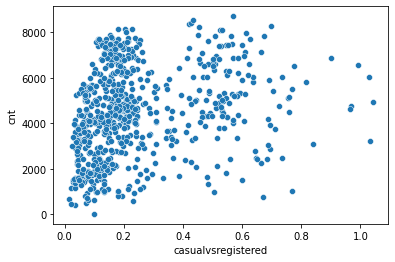

In [100]:
sns.scatterplot(df.casualvsregistered, df.cnt)
plt.show()

casualvsregistered represents the ratio of casual and registered.
Higher the value of casualvsregistered implies higher casual rides or lower registered rides


Mapping weathersit and season to categorical variable values so that we can create meaningful dummy variables later

In [101]:
df['weathersit'] = df['weathersit'].map({1:'Clear', 2:'Cloudy', 3:'Wet', 4:'Unsettled'})
df['season'] = df['season'].map({1:'Spring', 2:'Summer', 3:'Fall', 4:'Winter'})
df['mnth'] = df['mnth'].map({ 1 : "January",2 : "February",3 : "March",4 : "April",5 : "May",6 : "June",7 : "July",8 : "August",9 : "September",10 : "October",11 : "November",12 : "December"})
df['weekday'] = df['weekday'].map({0:'Sunday', 1:'Monday', 2:'Tuesday', 3:'Wednesday', 4:'Thursday', 5:'Friday', 6:'Saturday'})
df.head()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,casualvsregistered
0,1,Spring,0,January,0,Monday,1,Cloudy,14.110847,18.18125,80.5833,10.749882,985,0.506116
1,2,Spring,0,January,0,Tuesday,1,Cloudy,14.902598,17.68695,69.6087,16.652113,801,0.195522
2,3,Spring,0,January,0,Wednesday,1,Clear,8.050924,9.47025,43.7273,16.636703,1349,0.097640
3,4,Spring,0,January,0,Thursday,1,Clear,8.200000,10.60610,59.0435,10.739832,1562,0.074278
4,5,Spring,0,January,0,Friday,1,Clear,9.305237,11.46350,43.6957,12.522300,1600,0.054018


Analyzing some column pairs that seem highly correlated

C:\Users\ramnivas jat\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


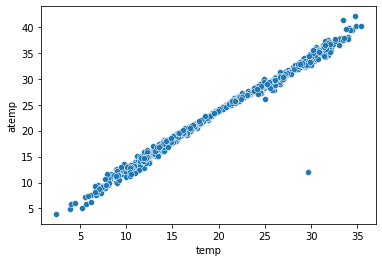

In [102]:
sns.scatterplot(df.temp, df.atemp)
plt.show()

temp and atemp are highly linearly correlated, and we are more concerned with atemp. Since this is a linear relationship, all the information from temp is represented by atemp and we can safely drop temp column

In [103]:
# Dropping temp column
df = df.drop('temp', axis=1)
df.head()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,atemp,hum,windspeed,cnt,casualvsregistered
0,1,Spring,0,January,0,Monday,1,Cloudy,18.18125,80.5833,10.749882,985,0.506116
1,2,Spring,0,January,0,Tuesday,1,Cloudy,17.68695,69.6087,16.652113,801,0.195522
2,3,Spring,0,January,0,Wednesday,1,Clear,9.47025,43.7273,16.636703,1349,0.097640
3,4,Spring,0,January,0,Thursday,1,Clear,10.60610,59.0435,10.739832,1562,0.074278
4,5,Spring,0,January,0,Friday,1,Clear,11.46350,43.6957,12.522300,1600,0.054018


# 3. Exploratory Data Analysis

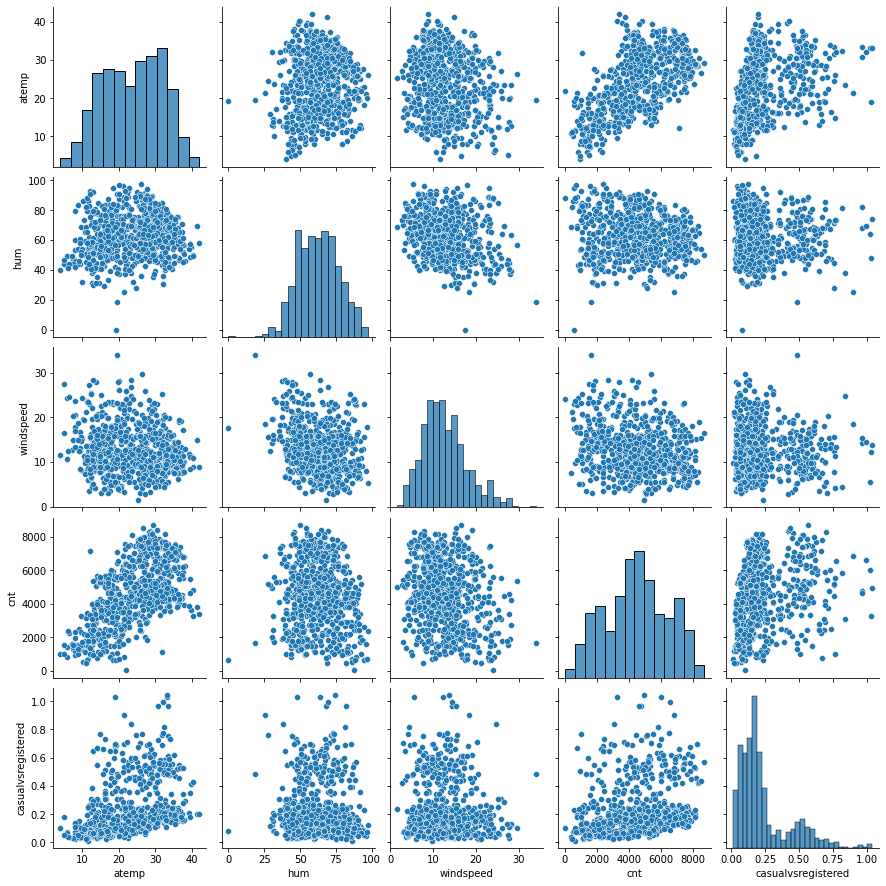

In [104]:
# Numeric variables
df_numeric = df[['atemp','hum','windspeed','cnt','casualvsregistered']]
sns.pairplot(df_numeric)
plt.show()

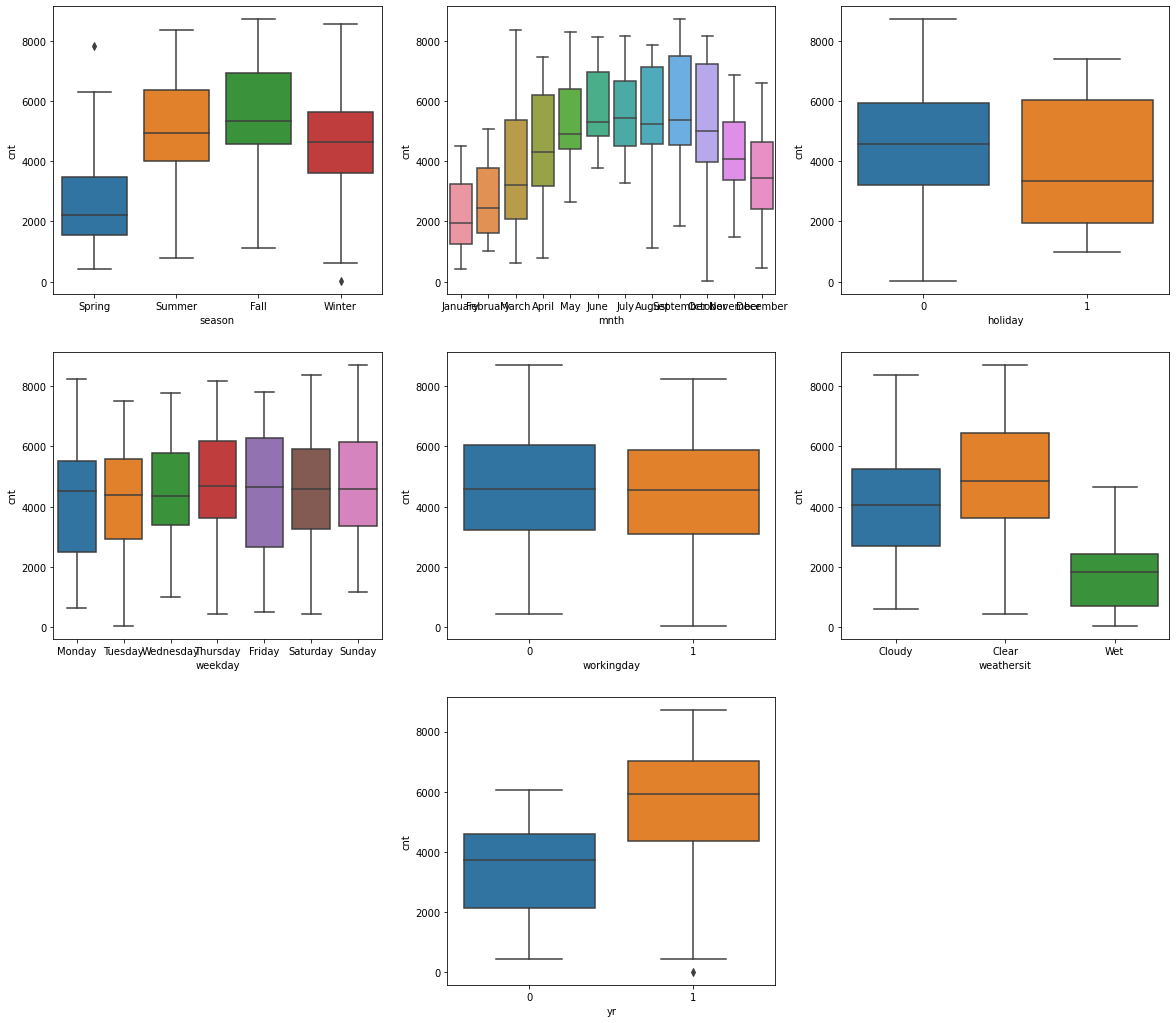

In [105]:
# Categorical Variables
plt.figure(figsize=(20, 18))
plt.subplot(3,3,1)
sns.boxplot(x = 'season', y = 'cnt', data = df)
plt.subplot(3,3,2)
sns.boxplot(x = 'mnth', y = 'cnt', data = df)
plt.subplot(3,3,3)
sns.boxplot(x = 'holiday', y = 'cnt', data = df)
plt.subplot(3,3,4)
sns.boxplot(x = 'weekday', y = 'cnt', data = df)
plt.subplot(3,3,5)
sns.boxplot(x = 'workingday', y = 'cnt', data = df)
plt.subplot(3,3,6)
sns.boxplot(x = 'weathersit', y = 'cnt', data = df)
plt.subplot(3,3,8)
sns.boxplot(x = 'yr', y = 'cnt', data = df)
plt.show()

1) cnt is more in Fall and least in spring

2) cnt is highest during august - september and lowest in january

3) cnt is slightly lower during holiday

4) cnt is more or less same during all days of the week

5) cnt is same during working days as well as non working days

6) cnt is highest during clear weather and lowest in wet weather

7) cnt is more in 2019 compared to 2018

# 4. Creating Dummy variables

In [106]:
#Creating dummy variables for season

season = pd.get_dummies(df.season, drop_first=True)
df = pd.concat([df, season], axis=1)
df = df.drop('season', axis=1)
df.head()

,instant,yr,mnth,holiday,weekday,workingday,weathersit,atemp,hum,windspeed,cnt,casualvsregistered,Spring,Summer,Winter
0,1,0,January,0,Monday,1,Cloudy,18.18125,80.5833,10.749882,985,0.506116,1,0,0
1,2,0,January,0,Tuesday,1,Cloudy,17.68695,69.6087,16.652113,801,0.195522,1,0,0
2,3,0,January,0,Wednesday,1,Clear,9.47025,43.7273,16.636703,1349,0.097640,1,0,0
3,4,0,January,0,Thursday,1,Clear,10.60610,59.0435,10.739832,1562,0.074278,1,0,0
4,5,0,January,0,Friday,1,Clear,11.46350,43.6957,12.522300,1600,0.054018,1,0,0


In [107]:
#Creating dummy variables for weathersit

weathersit = pd.get_dummies(df.weathersit, drop_first=True)
df = pd.concat([df, weathersit], axis=1)
df = df.drop('weathersit', axis=1)
df.head()

,instant,yr,mnth,holiday,weekday,workingday,atemp,hum,windspeed,cnt,casualvsregistered,Spring,Summer,Winter,Cloudy,Wet
0,1,0,January,0,Monday,1,18.18125,80.5833,10.749882,985,0.506116,1,0,0,1,0
1,2,0,January,0,Tuesday,1,17.68695,69.6087,16.652113,801,0.195522,1,0,0,1,0
2,3,0,January,0,Wednesday,1,9.47025,43.7273,16.636703,1349,0.097640,1,0,0,0,0
3,4,0,January,0,Thursday,1,10.60610,59.0435,10.739832,1562,0.074278,1,0,0,0,0
4,5,0,January,0,Friday,1,11.46350,43.6957,12.522300,1600,0.054018,1,0,0,0,0


In [108]:
#Creating dummy variables for mnth

mnth = pd.get_dummies(df.mnth, drop_first=True)
df = pd.concat([df, mnth], axis=1)
df = df.drop('mnth', axis=1)
df.head()

,instant,yr,holiday,weekday,workingday,atemp,hum,windspeed,cnt,casualvsregistered,...,December,February,January,July,June,March,May,November,October,September
0,1,0,0,Monday,1,18.18125,80.5833,10.749882,985,0.506116,...,0,0,1,0,0,0,0,0,0,0
1,2,0,0,Tuesday,1,17.68695,69.6087,16.652113,801,0.195522,...,0,0,1,0,0,0,0,0,0,0
2,3,0,0,Wednesday,1,9.47025,43.7273,16.636703,1349,0.097640,...,0,0,1,0,0,0,0,0,0,0
3,4,0,0,Thursday,1,10.60610,59.0435,10.739832,1562,0.074278,...,0,0,1,0,0,0,0,0,0,0
4,5,0,0,Friday,1,11.46350,43.6957,12.522300,1600,0.054018,...,0,0,1,0,0,0,0,0,0,0


In [109]:
#Creating dummy variables for weekday

weekday = pd.get_dummies(df.weekday, drop_first=True)
df = pd.concat([df, weekday], axis=1)
df = df.drop('weekday', axis=1)
df.head()

,instant,yr,holiday,workingday,atemp,hum,windspeed,cnt,casualvsregistered,Spring,...,May,November,October,September,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,1,0,0,1,18.18125,80.5833,10.749882,985,0.506116,1,...,0,0,0,0,1,0,0,0,0,0
1,2,0,0,1,17.68695,69.6087,16.652113,801,0.195522,1,...,0,0,0,0,0,0,0,0,1,0
2,3,0,0,1,9.47025,43.7273,16.636703,1349,0.097640,1,...,0,0,0,0,0,0,0,0,0,1
3,4,0,0,1,10.60610,59.0435,10.739832,1562,0.074278,1,...,0,0,0,0,0,0,0,1,0,0
4,5,0,0,1,11.46350,43.6957,12.522300,1600,0.054018,1,...,0,0,0,0,0,0,0,0,0,0


In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   instant             730 non-null    int64  
 1   yr                  730 non-null    int64  
 2   holiday             730 non-null    int64  
 3   workingday          730 non-null    int64  
 4   atemp               730 non-null    float64
 5   hum                 730 non-null    float64
 6   windspeed           730 non-null    float64
 7   cnt                 730 non-null    int64  
 8   casualvsregistered  730 non-null    float64
 9   Spring              730 non-null    uint8  
 10  Summer              730 non-null    uint8  
 11  Winter              730 non-null    uint8  
 12  Cloudy              730 non-null    uint8  
 13  Wet                 730 non-null    uint8  
 14  August              730 non-null    uint8  
 15  December            730 non-null    uint8  
 16  February

# 5 Feature Selection

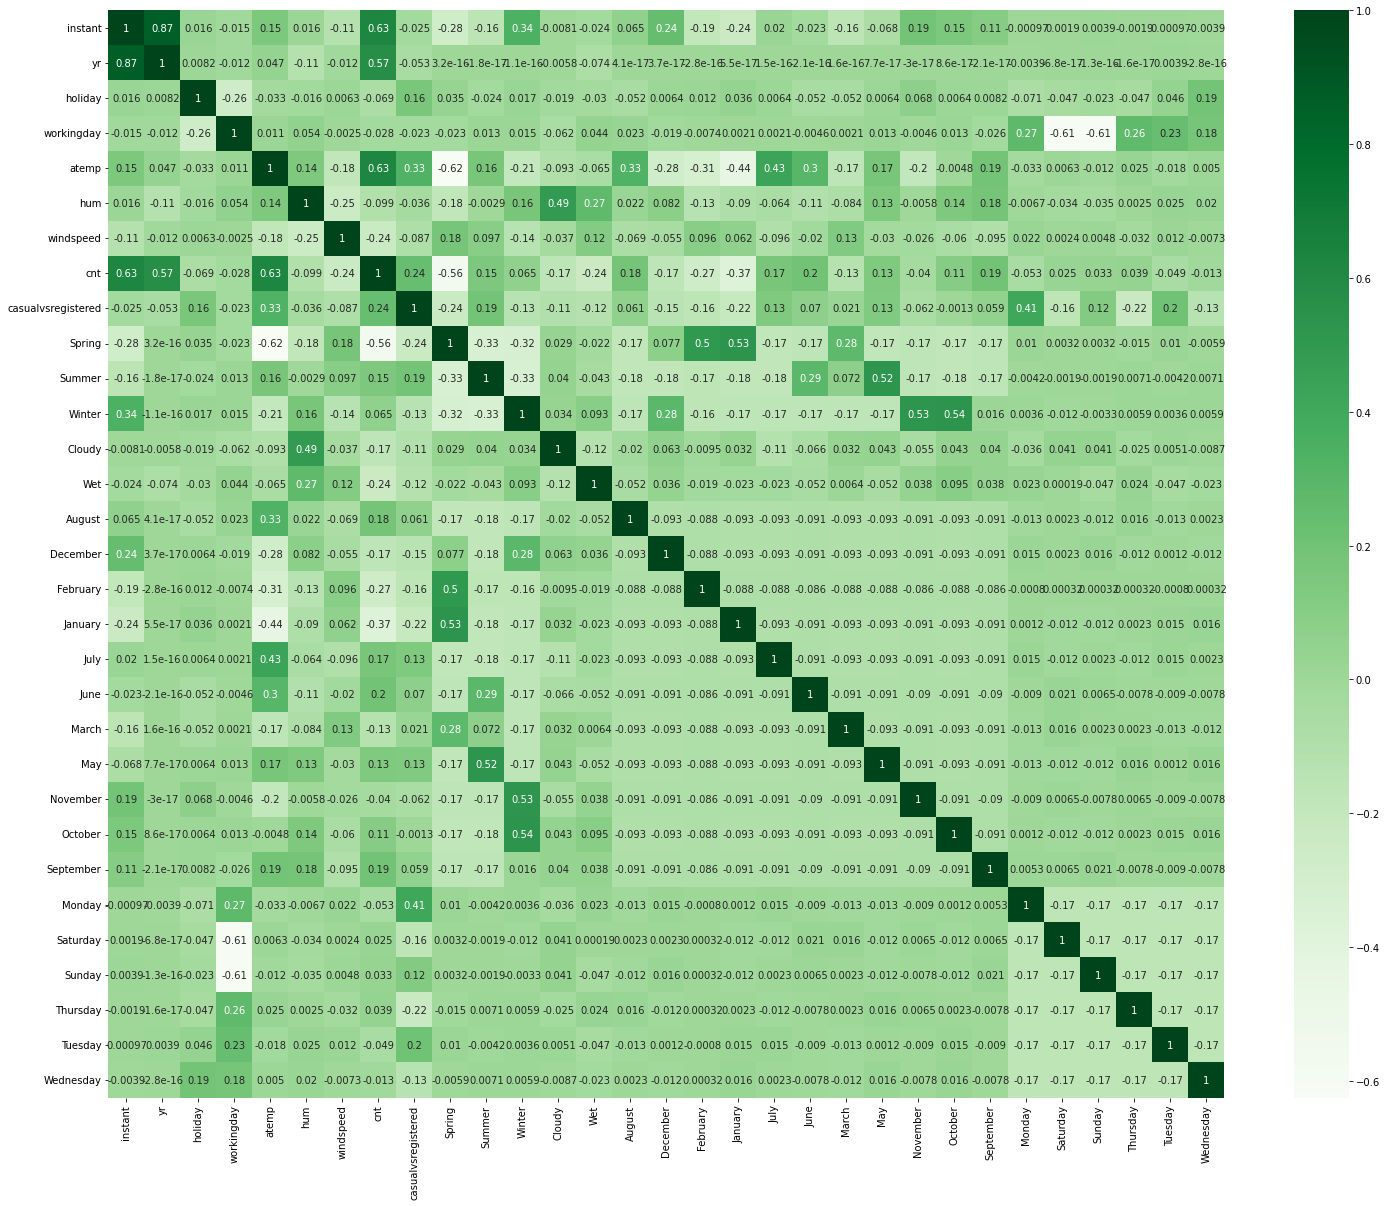

In [111]:
plt.figure(figsize = (25,20))
sns.heatmap(df.corr(), annot = True, cmap="Greens")
plt.show()

Correlation

atemp has the highest correlation with cnt followed by yr

In [112]:
df_train, df_test = train_test_split(df, train_size=0.7, test_size=0.3, random_state=100)
df_train.shape

(510, 31)

In [113]:
scaler = MinMaxScaler()
df_train[['atemp', 'hum', 'windspeed', 'casualvsregistered', 'cnt']] = scaler.fit_transform(df_train[['atemp', 'hum', 'windspeed', 'casualvsregistered', 'cnt']])
df_train.head()

,instant,yr,holiday,workingday,atemp,hum,windspeed,cnt,casualvsregistered,Spring,...,May,November,October,September,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
653,654,1,0,1,0.501133,0.575354,0.300794,0.864243,0.122559,0,...,0,0,1,0,0,0,0,0,0,1
576,577,1,0,1,0.766351,0.725633,0.264686,0.827658,0.137611,0,...,0,0,0,0,0,0,0,0,0,1
426,427,1,0,0,0.438975,0.640189,0.255342,0.465255,0.285807,1,...,0,0,0,0,0,0,1,0,0,0
728,729,1,0,1,0.200348,0.498067,0.663106,0.204096,0.234092,1,...,0,0,0,0,1,0,0,0,0,0
482,483,1,0,0,0.391735,0.504508,0.188475,0.482973,0.338193,0,...,0,0,0,0,0,0,1,0,0,0


In [114]:
y_train = df_train.pop('cnt')
X_train = df_train
X_train.head()

,instant,yr,holiday,workingday,atemp,hum,windspeed,casualvsregistered,Spring,Summer,...,May,November,October,September,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
653,654,1,0,1,0.501133,0.575354,0.300794,0.122559,0,0,...,0,0,1,0,0,0,0,0,0,1
576,577,1,0,1,0.766351,0.725633,0.264686,0.137611,0,0,...,0,0,0,0,0,0,0,0,0,1
426,427,1,0,0,0.438975,0.640189,0.255342,0.285807,1,0,...,0,0,0,0,0,0,1,0,0,0
728,729,1,0,1,0.200348,0.498067,0.663106,0.234092,1,0,...,0,0,0,0,1,0,0,0,0,0
482,483,1,0,0,0.391735,0.504508,0.188475,0.338193,0,1,...,0,0,0,0,0,0,1,0,0,0


# 6. Creating the Model

In [115]:
lm_sk = LinearRegression()
lm_sk.fit(X_train, y_train)

LinearRegression()

In [116]:
lm_sk.coef_

array([-2.65529573e-05,  2.47198777e-01, -1.55240239e-01, -6.73897160e-02,
        3.75568318e-01, -1.42778509e-01, -1.51129170e-01,  1.19257070e-01,
       -5.35216662e-02,  2.74085340e-02,  1.12276656e-01, -5.75690096e-02,
       -2.37671341e-01,  5.29694331e-02, -4.38342593e-02, -3.94899338e-02,
       -6.66651150e-02, -3.60464260e-03,  3.40524791e-02, -3.63951497e-03,
        4.12346384e-02, -4.63239032e-02,  3.05188577e-03,  1.00967331e-01,
       -6.13240446e-02, -6.23227492e-02, -7.49158111e-02,  6.34710237e-03,
       -4.75828703e-02, -1.28323804e-02])

Applying RFE to select top 15 features

In [117]:
rfe = RFE(lm_sk, n_features_to_select=15)
rfe = rfe.fit(X_train, y_train)
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('instant', False, 16),
 ('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('atemp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('casualvsregistered', True, 1),
 ('Spring', True, 1),
 ('Summer', False, 10),
 ('Winter', True, 1),
 ('Cloudy', True, 1),
 ('Wet', True, 1),
 ('August', False, 8),
 ('December', False, 5),
 ('February', False, 9),
 ('January', False, 3),
 ('July', False, 13),
 ('June', False, 7),
 ('March', False, 14),
 ('May', False, 6),
 ('November', False, 4),
 ('October', False, 15),
 ('September', True, 1),
 ('Monday', True, 1),
 ('Saturday', True, 1),
 ('Sunday', True, 1),
 ('Thursday', False, 12),
 ('Tuesday', False, 2),
 ('Wednesday', False, 11)]

In [118]:
X_train = X_train[X_train.columns[rfe.support_]]
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 510 entries, 653 to 79
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   yr                  510 non-null    int64  
 1   holiday             510 non-null    int64  
 2   workingday          510 non-null    int64  
 3   atemp               510 non-null    float64
 4   hum                 510 non-null    float64
 5   windspeed           510 non-null    float64
 6   casualvsregistered  510 non-null    float64
 7   Spring              510 non-null    uint8  
 8   Winter              510 non-null    uint8  
 9   Cloudy              510 non-null    uint8  
 10  Wet                 510 non-null    uint8  
 11  September           510 non-null    uint8  
 12  Monday              510 non-null    uint8  
 13  Saturday            510 non-null    uint8  
 14  Sunday              510 non-null    uint8  
dtypes: float64(4), int64(3), uint8(8)
memory usage: 35.9 KB


Manual feature elimination

Using statsmodels library to manually remove the least useful variables

In [126]:
X_train_sm = sm.add_constant(X_train)
X_train_sm.head()
lr_model_1 = sm.OLS(y_train, X_train_sm).fit()
lr_model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     168.1
Date:                Wed, 06 Jul 2022   Prob (F-statistic):          6.07e-183
Time:                        15:08:24   Log-Likelihood:                 499.77
No. Observations:                 510   AIC:                            -967.5
Df Residuals:                     494   BIC:                            -899.8
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.4004      0.080      4.992      0.000       0.243       0.558
yr                     0.2355      0.008     28.117      0.000       0.219       0.252
holiday               -0.1686      0.067     -2.523      0.012      -0.300      -0.037
workingday            -0.0668      0.072     -0.922      0.357      -0.209       0.076
atemp                  0.4229      0.032     13.398      0.000       0.361       0.485
hum                   -0.1394      0.038     -3.622      0.000      -0.215      -0.064
windspeed             -0.1429      0.026     -5.462      0.000      -0.194      -0.091
casualvsregistered     0.0971      0.029      3.365      0.001       0.040       0.154
Spring                -0.1151      0.015     -7.638      0.000      -0.145      -0.085
Winter                 0.0538      0.012      4.335      0.000       0.029       0.078
Cloudy                -0.0554      0.011     -5.106      0.000      -0.077      -0.034
Wet                   -0.2356      0.027     -8.672      0.000      -0.289      -0.182
September              0.0741      0.016      4.757      0.000       0.043       0.105
Monday                -0.0433      0.014     -3.136      0.002      -0.070      -0.016
Saturday              -0.0487      0.072     -0.674      0.500      -0.191       0.093
Sunday                -0.0606      0.072     -0.838      0.402      -0.203       0.081
==============================================================================
Omnibus:                       81.070   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              196.345
Skew:                          -0.819   Prob(JB):                     2.31e-43
Kurtosis:                       5.560   Cond. No.                         66.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [127]:
def vif(df):
    vif = pd.DataFrame()
    vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif['columns'] = df.columns
    return vif.sort_values('VIF', ascending=False)
vif(X_train_sm).head(20)

,VIF,columns
0,385.254236,const
3,64.536761,workingday
15,37.031845,Sunday
14,35.188311,Saturday
2,6.641327,holiday
4,2.685840,atemp
8,2.501876,Spring
5,1.884702,hum
9,1.727282,Winter
7,1.693887,casualvsregistered


We see that Saturday has highest p-value of 0.5 as well as a very high VIF of 35 So we will drop Saturday column

In [128]:
X_train_sm2 = X_train_sm.drop('Saturday', axis=1)
X_train_sm2.head()

,const,yr,holiday,workingday,atemp,hum,windspeed,casualvsregistered,Spring,Winter,Cloudy,Wet,September,Monday,Sunday
653,1.0,1,0,1,0.501133,0.575354,0.300794,0.122559,0,1,0,0,0,0,0
576,1.0,1,0,1,0.766351,0.725633,0.264686,0.137611,0,0,0,0,0,0,0
426,1.0,1,0,0,0.438975,0.640189,0.255342,0.285807,1,0,1,0,0,0,1
728,1.0,1,0,1,0.200348,0.498067,0.663106,0.234092,1,0,0,0,0,1,0
482,1.0,1,0,0,0.391735,0.504508,0.188475,0.338193,0,0,1,0,0,0,1


In [129]:
lr_model_2 = sm.OLS(y_train, X_train_sm2).fit()
lr_model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     180.2
Date:                Wed, 06 Jul 2022   Prob (F-statistic):          5.56e-184
Time:                        15:08:28   Log-Likelihood:                 499.53
No. Observations:                 510   AIC:                            -969.1
Df Residuals:                     495   BIC:                            -905.5
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.3512      0.033     10.568      0.000       0.286       0.416
yr                     0.2359      0.008     28.247      0.000       0.219       0.252
holiday               -0.1278      0.028     -4.490      0.000      -0.184      -0.072
workingday            -0.0187      0.013     -1.478      0.140      -0.044       0.006
atemp                  0.4232      0.032     13.416      0.000       0.361       0.485
hum                   -0.1382      0.038     -3.596      0.000      -0.214      -0.063
windspeed             -0.1433      0.026     -5.484      0.000      -0.195      -0.092
casualvsregistered     0.0973      0.029      3.373      0.001       0.041       0.154
Spring                -0.1146      0.015     -7.617      0.000      -0.144      -0.085
Winter                 0.0533      0.012      4.305      0.000       0.029       0.078
Cloudy                -0.0554      0.011     -5.104      0.000      -0.077      -0.034
Wet                   -0.2356      0.027     -8.677      0.000      -0.289      -0.182
September              0.0744      0.016      4.782      0.000       0.044       0.105
Monday                -0.0433      0.014     -3.138      0.002      -0.070      -0.016
Sunday                -0.0131      0.016     -0.809      0.419      -0.045       0.019
==============================================================================
Omnibus:                       80.994   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              192.558
Skew:                          -0.825   Prob(JB):                     1.54e-42
Kurtosis:                       5.518   Cond. No.                         20.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [130]:
vif(X_train_sm2).head(20)

,VIF,columns
0,66.210501,const
4,2.685326,atemp
8,2.495602,Spring
3,1.975635,workingday
5,1.880290,hum
14,1.852647,Sunday
9,1.721121,Winter
7,1.693722,casualvsregistered
10,1.591073,Cloudy
13,1.495927,Monday


Sunday has a very high p-value of 0.419, hence dropping it

In [131]:
X_train_sm3 = X_train_sm2.drop('Sunday', axis=1)
X_train_sm3.head()

,const,yr,holiday,workingday,atemp,hum,windspeed,casualvsregistered,Spring,Winter,Cloudy,Wet,September,Monday
653,1.0,1,0,1,0.501133,0.575354,0.300794,0.122559,0,1,0,0,0,0
576,1.0,1,0,1,0.766351,0.725633,0.264686,0.137611,0,0,0,0,0,0
426,1.0,1,0,0,0.438975,0.640189,0.255342,0.285807,1,0,1,0,0,0
728,1.0,1,0,1,0.200348,0.498067,0.663106,0.234092,1,0,0,0,0,1
482,1.0,1,0,0,0.391735,0.504508,0.188475,0.338193,0,0,1,0,0,0


In [132]:
lr_model_3 = sm.OLS(y_train, X_train_sm3).fit()
lr_model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     194.2
Date:                Wed, 06 Jul 2022   Prob (F-statistic):          5.42e-185
Time:                        15:09:35   Log-Likelihood:                 499.20
No. Observations:                 510   AIC:                            -970.4
Df Residuals:                     496   BIC:                            -911.1
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.3452      0.032     10.657      0.000       0.282       0.409
yr                     0.2356      0.008     28.247      0.000       0.219       0.252
holiday               -0.1214      0.027     -4.442      0.000      -0.175      -0.068
workingday            -0.0122      0.010     -1.248      0.213      -0.032       0.007
atemp                  0.4242      0.032     13.468      0.000       0.362       0.486
hum                   -0.1377      0.038     -3.584      0.000      -0.213      -0.062
windspeed             -0.1440      0.026     -5.515      0.000      -0.195      -0.093
casualvsregistered     0.0922      0.028      3.277      0.001       0.037       0.147
Spring                -0.1148      0.015     -7.636      0.000      -0.144      -0.085
Winter                 0.0530      0.012      4.284      0.000       0.029       0.077
Cloudy                -0.0558      0.011     -5.146      0.000      -0.077      -0.034
Wet                   -0.2354      0.027     -8.673      0.000      -0.289      -0.182
September              0.0744      0.016      4.787      0.000       0.044       0.105
Monday                -0.0420      0.014     -3.066      0.002      -0.069      -0.015
==============================================================================
Omnibus:                       82.493   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              199.871
Skew:                          -0.832   Prob(JB):                     3.97e-44
Kurtosis:                       5.576   Cond. No.                         20.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [133]:
vif(X_train_sm3).head(20)

,VIF,columns
0,62.959207,const
4,2.680450,atemp
8,2.494767,Spring
5,1.879773,hum
9,1.719605,Winter
7,1.612108,casualvsregistered
10,1.588076,Cloudy
13,1.476101,Monday
11,1.261395,Wet
3,1.185920,workingday


Workingday has a high p-value of 0.213, hence dropping it

In [134]:
X_train_sm4 = X_train_sm3.drop('workingday', axis=1)
X_train_sm4.head()

,const,yr,holiday,atemp,hum,windspeed,casualvsregistered,Spring,Winter,Cloudy,Wet,September,Monday
653,1.0,1,0,0.501133,0.575354,0.300794,0.122559,0,1,0,0,0,0
576,1.0,1,0,0.766351,0.725633,0.264686,0.137611,0,0,0,0,0,0
426,1.0,1,0,0.438975,0.640189,0.255342,0.285807,1,0,1,0,0,0
728,1.0,1,0,0.200348,0.498067,0.663106,0.234092,1,0,0,0,0,1
482,1.0,1,0,0.391735,0.504508,0.188475,0.338193,0,0,1,0,0,0


In [135]:
lr_model_4 = sm.OLS(y_train, X_train_sm4).fit()
lr_model_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     210.0
Date:                Wed, 06 Jul 2022   Prob (F-statistic):          7.93e-186
Time:                        15:11:05   Log-Likelihood:                 498.40
No. Observations:                 510   AIC:                            -970.8
Df Residuals:                     497   BIC:                            -915.7
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.3378      0.032     10.602      0.000       0.275       0.400
yr                     0.2357      0.008     28.238      0.000       0.219       0.252
holiday               -0.1137      0.027     -4.268      0.000      -0.166      -0.061
atemp                  0.4242      0.032     13.459      0.000       0.362       0.486
hum                   -0.1413      0.038     -3.687      0.000      -0.217      -0.066
windspeed             -0.1444      0.026     -5.526      0.000      -0.196      -0.093
casualvsregistered     0.0967      0.028      3.464      0.001       0.042       0.152
Spring                -0.1142      0.015     -7.599      0.000      -0.144      -0.085
Winter                 0.0529      0.012      4.274      0.000       0.029       0.077
Cloudy                -0.0542      0.011     -5.032      0.000      -0.075      -0.033
Wet                   -0.2332      0.027     -8.607      0.000      -0.286      -0.180
September              0.0748      0.016      4.809      0.000       0.044       0.105
Monday                -0.0470      0.013     -3.578      0.000      -0.073      -0.021
==============================================================================
Omnibus:                       79.064   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              193.632
Skew:                          -0.796   Prob(JB):                     8.98e-43
Kurtosis:                       5.564   Cond. No.                         18.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [136]:
vif(X_train_sm4).head(20)

,VIF,columns
0,60.852412,const
3,2.680448,atemp
7,2.492691,Spring
4,1.868946,hum
8,1.719540,Winter
6,1.585624,casualvsregistered
9,1.566598,Cloudy
12,1.352750,Monday
10,1.256359,Wet
5,1.177111,windspeed


# 7. Model Analysis

# #Statistics

R-squared: 0.835, Adj. R-squared: 0.831
        
Both R-squared and Adjuster R-Squared are close together which indicates no unnecessary features

P(F-statistic): 7.93e-186 (~0)
    
P(F) is low, indicating good fit of the entire model

P(values) of individual coefficents zero or almost zero indicating significance of the features

VIF values of all variables are under 3 indicating no multicolinearity

# Interpretation

The equation of the model is as follows
cnt = 0.2357 × yr - 0.1137 × holiday + 0.4242 × atemp - 0.1413 × hum - 0.1444 × windspeed + 0.0967 × casualvsregistered - 0.1142 × Spring + 0.0529 × Winter - 0.0542 × Cloudy - 0.2332 × Wet + 0.0748 × September - 0.0470 × Monday + 0.3378

The individual variables can be interpreted as:

yr: A unit increase in yr increases cnt by 0.2357

holiday: A unit increase in holiday decreases cnt by 0.1137

atemp: A unit increase in holiday increases cnt by 0.4242

hum: A unit increase in holiday decreases cnt by 0.1413

windspeed: A unit increase in holiday decreases cnt by 0.1444

casualvsregistered: An unit increase in holiday decreases cnt by 0.0967

Spring: A unit increase in holiday decreases cnt by 0.1142

Winter: A unit increase in holiday increases cnt by 0.0529

Cloudy: A unit increase in holiday decreases cnt by 0.0542

Wet: A unit increase in holiday decreases cnt by 0.2332

September: A unit increase in holiday increases cnt by 0.0748

Monday: A unit increase in holiday decreases cnt by 0.0470

C:\Users\ramnivas jat\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


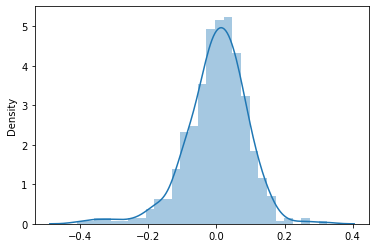

In [138]:
# plotting residuals
y_train_pred = lr_model_4.predict(X_train_sm4)
residuals = y_train - y_train_pred
sns.distplot(residuals)
plt.show()

C:\Users\ramnivas jat\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


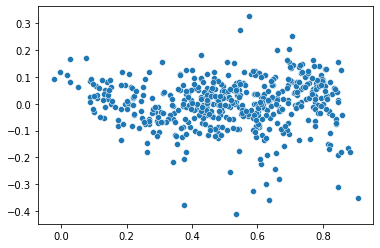

In [139]:
# plotting residuals vs y_train_pred
sns.scatterplot(y_train_pred, residuals)
plt.show()

residuals are evenly spread throughout, suggesting good homoscedasticity

Scaling the test data and adding constant

In [140]:
df_test[['atemp', 'hum', 'windspeed', 'casualvsregistered', 'cnt']] = scaler.transform(df_test[['atemp', 'hum', 'windspeed', 'casualvsregistered', 'cnt']])
y_test = df_test.pop('cnt')
X_test = df_test
X_test_sm = sm.add_constant(X_test)
X_test_sm.head()

,const,instant,yr,holiday,workingday,atemp,hum,windspeed,casualvsregistered,Spring,...,May,November,October,September,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
184,1.0,185,0,1,0,0.769660,0.657364,0.084219,0.987411,0,...,0,0,0,0,0,0,0,0,0,1
535,1.0,536,1,0,1,0.842587,0.610133,0.153728,0.145773,0,...,0,0,0,0,0,0,0,1,0,0
299,1.0,300,0,0,0,0.496145,0.837699,0.334206,0.083457,0,...,0,0,1,0,0,1,0,0,0,0
221,1.0,222,0,0,1,0.795343,0.437098,0.339570,0.207566,0,...,0,0,0,0,0,0,0,0,0,0
152,1.0,153,0,0,0,0.741471,0.314298,0.537414,0.156063,0,...,0,0,0,0,0,1,0,0,0,0


# 8. Model Evaluation

Calculating MSE of test data

In [145]:
X_test_sm = X_test_sm[X_train_sm4.columns]
y_test_pred = lr_model_4.predict(X_test_sm)
mean_squared_error(y_true=y_test, y_pred=y_test_pred)

0.00843797115645063

In [146]:
r2_score(y_true=y_test, y_pred=y_test_pred)

0.822342823818226

The R-Squared score of the test data is close to that of the training data, therefore our model can be considered as a good fit